In [1]:
import geopandas as gpd 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from ipywidgets import widgets

In [2]:
# load the data
dataset = gpd.read_file('./data.gpkg')
print('dataset size: ', dataset.shape[0])
print('dataset columns: ', dataset.columns.values)

dataset size:  1456
dataset columns:  ['TxID' 'StrNr' 'Strak' 'BdlNr' 'Bandel' 'Forbind_1' 'PlSignFr' 'PlNamnFr'
 'PlSignTi' 'PlNamnTi' 'AntalSpar' 'Elektrif' 'Infraforv' 'UHDist' 'TrSys'
 'TComr' 'Status' 'BdlSeq' 'geometry']


In [3]:
# load the dataset containg the information if a passenger can board a train
stations = gpd.read_file('./stations.gpkg')
stations = stations[stations.PlTyp != 'dp*']

print('dataset size: ', stations.shape[0])
print('dataset columns: ', stations.columns.values)
# the column ResUtbyte is the one we are interested in below:

dataset size:  1611
dataset columns:  ['OBJECTID' 'TplKod' 'Sign' 'SignTxt' 'PlNamn' 'PlTyp' 'PltypBesk'
 'Tillh_dpd' 'Tillh_dp_lp' 'PlStatus' 'ResUtbyte' 'Lastpl' 'Hamn'
 'Kombiterm' 'Northing' 'Easting' 'Latitud' 'Longitud' 'Moh' 'Strak'
 'Bandel' 'Kmtalfr' 'Kmtalti' 'Region' 'TL' 'UH' 'Dignitet' 'Skapad'
 'geometry']


In [4]:
# load map of sweden (used for plotting)
sweden = gpd.read_file('./swedish_municipalities.geojson')
sweden = sweden.to_crs('EPSG:3006')

In [5]:
filtered_dataset = dataset.copy()

In [6]:
remove_list = stations[stations.ResUtbyte != 'j'].SignTxt.values
for to_remove in filtered_dataset[(filtered_dataset.PlSignFr.isin(remove_list))].PlSignFr.unique():

    station = stations[stations.SignTxt == to_remove] 

    matched = stations[stations.Tillh_dp_lp == station.PlNamn.values[0]]
    if matched.shape[0] != 0:
        if matched.ResUtbyte.values[0] == 'j':
            continue                   
        
    # find rows with station that should be removed
    pre_row = filtered_dataset[(filtered_dataset.PlSignTi == to_remove)]
    suc_row = filtered_dataset[(filtered_dataset.PlSignFr == to_remove)]

    filtered_dataset.loc[pre_row.index,'PlSignTi'] = suc_row.PlSignTi.values[0]
    filtered_dataset.loc[pre_row.index,'PlNamnTi'] = suc_row.PlNamnTi.values[0]

    filtered_dataset.drop(suc_row.index, inplace=True, axis=0)
filtered_dataset

,TxID,StrNr,Strak,BdlNr,Bandel,Forbind_1,PlSignFr,PlNamnFr,PlSignTi,PlNamnTi,AntalSpar,Elektrif,Infraforv,UHDist,TrSys,TComr,Status,BdlSeq,geometry
2,T230282,8.0,Norra stambanan,217.0,Bollnäs-Ljusdal,Ab-Vl,Ab,Arbrå,Vl,Vallsta,1.0,Ja,Trafikverket infrastruktur,Mitt,sysH,Gä,Öppen,217104.0,"LINESTRING (573518.164 6816036.145, 573517.398..."
8,T230195,99.0,Inlandsbanan,161.0,(Gällivare)-(Arvidsjaur),Ajr-Nkr,Ajr,Arvidsjaur,Nkr,Norra Kikkejaur,1.0,Nej,Inlandsbanan AB,IBAB,sysM,Gä,Öppen,161101.0,"LINESTRING (692144.289 7280445.156, 692142.397..."
9,T230031,21.0,Malmbanan,111.0,(Peuravaara)-Riksgränsen-(Björnfjell),Ak-Bln,Ak,Abisko östra,Bln,Björkliden,1.0,Ja,Trafikverket infrastruktur,Nord,sysH,Bdn,Öppen,111110.0,"LINESTRING (657624.433 7586639.317, 657620.394..."
11,T231056,74.0,(Alvhem) - Lilla Edet,666.0,(Alvhem)-Lilla Edet,Alh-Löö,Alh,Alvhem,Let,Lilla Edet,1.0,Nej,Trafikverket infrastruktur,Väst,sysS,G,Öppen,666101.0,"LINESTRING (332165.875 6433556.851, 331653.000..."
12,T230989,11.0,Norge-/Vänerbanan med Nordlänken,635.0,Öxnered-(Älvängen),Alh-Än,Alh,Alvhem,Än,Älvängen,2.0,Ja,Trafikverket infrastruktur,Väst,sysH,G,Öppen,635106.0,"LINESTRING (332165.875 6433556.851, 332165.685..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,T231204,24.0,Malmö närområde,901.0,Burlöv-Malmö C.Arlöv-Lockarp,Övn-Fsb,Övn,Östervärn,Sea,Svedala,2.0,Ja,Trafikverket infrastruktur,Syd,sysH,M,Öppen,901105.0,"LINESTRING (376125.298 6164076.776, 376258.000..."
1450,T231312,94.0,(Östervärn) - Brågarp,964.0,(Östervärn)-Brågarp,Övn-Sege,Övn,Östervärn,Båp,Brågarp,1.0,Nej,Trafikverket infrastruktur,Syd,None,M,Ejunderh,964101.0,"LINESTRING (376125.298 6164076.776, 376125.412..."
1452,T230984,11.0,Norge-/Vänerbanan med Nordlänken,635.0,Öxnered-(Älvängen),Öx-Thn,Öx,Öxnered,Thn,Trollhättan,2.0,Ja,Trafikverket infrastruktur,Väst,sysH,G,Öppen,635101.0,"LINESTRING (340504.707 6471923.075, 340458.000..."
1453,T231025,15.0,Älvsborgsbanan,652.0,(Öxnered)-(Håkantorp),Öx-Vg,Öx,Öxnered,Vg,Vänersborg central,1.0,Ja,Trafikverket infrastruktur,Väst,sysH,G,Öppen,652101.0,"LINESTRING (340504.707 6471923.075, 340597.519..."


In [7]:
df = filtered_dataset[['PlSignFr', 'PlSignTi']]
df

,PlSignFr,PlSignTi
2,Ab,Vl
8,Ajr,Nkr
9,Ak,Bln
11,Alh,Let
12,Alh,Än
...,...,...
1449,Övn,Sea
1450,Övn,Båp
1452,Öx,Thn
1453,Öx,Vg


In [8]:
df = pd.concat([df, pd.DataFrame(data=df[['PlSignTi', 'PlSignFr']].values, columns=['PlSignFr', 'PlSignTi'])])
df

,PlSignFr,PlSignTi
2,Ab,Vl
8,Ajr,Nkr
9,Ak,Bln
11,Alh,Let
12,Alh,Än
...,...,...
770,Sea,Övn
771,Båp,Övn
772,Thn,Öx
773,Vg,Öx


In [9]:
adj_matrix = pd.crosstab(df.PlSignFr, df.PlSignTi)
adj_matrix

PlSignTi,Ab,Aik,Ajr,Ak,Alh,Ar,Arb,Arnc,Arnn,Arns,...,Ökn,Önd,Ör,Örs,Ös,Öso,Öte,Övm,Övn,Öx
PlSignFr,,,,,,,,,,,,,,,,,,,,,
Ab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ajr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Öso,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Öte,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Övm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
adj_matrix_numpy = adj_matrix.to_numpy()


In [11]:
from_w = widgets.Combobox(
    placeholder='Choose ',
    options=stations.PlNamn.to_list(),
    description='Fran',
    ensure_option=True,
    disabled=False
)

to_w = widgets.Combobox(
    placeholder='Choose ',
    options=stations.PlNamn.to_list(),
    description='Till',
    ensure_option=True,
    disabled=False
)

display(from_w)
display(to_w)


Combobox(value='', description='Fran', ensure_option=True, options=('Vinnö', 'Triabo', 'Totebo', 'Lundsbrunn',…

Combobox(value='', description='Till', ensure_option=True, options=('Vinnö', 'Triabo', 'Totebo', 'Lundsbrunn',…

In [15]:
from_station = stations[stations.PlNamn == from_w.value].Sign.values[0]
to_station = stations[stations.PlNamn == to_w.value].Sign.values[0]

cols = adj_matrix.columns.to_list()

from_index = cols.index(from_station)
to_index = cols.index(to_station)

ajdc = adj_matrix_numpy.copy()
n = 1

non_zero = np.argwhere(ajdc[from_index, :] != 0)


searched = [[]] 

for i in non_zero:
    searched[0].append(cols[i[0]])
    print(from_station,cols[i[0]])

while ajdc[from_index, to_index] == 0: 
  
    n+=1
    
    ajdc = np.linalg.matrix_power(adj_matrix_numpy, n)
    non_zero = np.argwhere(ajdc[from_index, :] != 0)
    searched.append([])
    for i in non_zero:
        searched[n-1].append(cols[i[0]])
    print(searched[n-1])
    



non_zero = np.argwhere(ajdc[from_index, :] != 0)
for i in non_zero:
        searched[n-1].append(cols[i[0]])
        print(from_station,cols[i[0]])
print(searched)
print(n)



Cst Ke
Cst Sst
['Cst', 'Sci', 'Sub', 'Vn', 'Åbe']
['Ke', 'Sod', 'Spå', 'Sst', 'Äs']
['Bkb', 'Cst', 'Fas', 'Hu', 'Sci', 'Sub', 'Vn', 'Åbe']
['Flb', 'Jkb', 'Ke', 'Skg', 'Sod', 'Spå', 'Sst', 'Äs']
['Bkb', 'Cst', 'Fas', 'Hnd', 'Hu', 'Khä', 'Sci', 'Sub', 'Söö', 'Tu', 'Vn', 'Åbe']
['Flb', 'Gau', 'Jbo', 'Jkb', 'Jn', 'Ke', 'Kän', 'Nkv', 'Skg', 'Sod', 'Spå', 'Sst', 'Söu', 'Äs']
['Bkb', 'Bro', 'Cst', 'Fas', 'Hnd', 'Hu', 'Jn', 'Khä', 'Lg', 'Mö', 'Sci', 'Sub', 'Söd', 'Söu', 'Söö', 'Tu', 'Vhd', 'Vhe', 'Vn', 'Åbe', 'Öte']
['Bål', 'Flb', 'Gau', 'Gn', 'Jbo', 'Jkb', 'Jn', 'Ke', 'Kän', 'Mö', 'Nk', 'Nkv', 'Sgs', 'Skg', 'Sod', 'Spå', 'Sst', 'Söc', 'Söd', 'Söu', 'Söö', 'Ts', 'Vhd', 'Äs', 'Öte']
['Bkb', 'Bro', 'Cst', 'Ep', 'Et', 'Fas', 'Flb', 'Fle', 'Gau', 'Gn', 'Hfa', 'Hnd', 'Hu', 'Jn', 'Khä', 'Kon', 'Lg', 'Mö', 'Nk', 'Nkv', 'Sci', 'Sub', 'Söc', 'Söd', 'Söu', 'Söö', 'Tu', 'Vhd', 'Vhe', 'Vn', 'Åbe', 'Öte']
['Bål', 'Flb', 'Fle', 'Gau', 'Gn', 'Hnä', 'Hu', 'Jbo', 'Jkb', 'Jn', 'K', 'Ke', 'Kon', 'Ksu', 'Kän', 'L

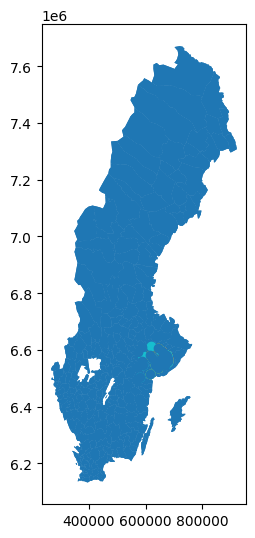

In [14]:
fig, ax = plt.subplots()

fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

def init():
    sweden.geometry.plot(ax=ax, zorder=1)

def animate(i):
    k = stations[stations.Sign.isin(searched[i])]
    k.geometry.plot(ax=ax, zorder=2)

anim = FuncAnimation(fig, animate, init_func=init,interval=200,repeat_delay=300, frames=len(searched))
anim.save('kalle.gif')

In [ ]:
n = 1
result = np.linalg.matrix_power(adj_matrix_numpy , n)
print("grannmatrisen upphöjt till", n, "är:")
print(result)

# Räkna antalet icke-noll element i varje rad
non_zero_counts = np.count_nonzero(result, axis=1)

# Hämta indexen för de 10 raderna med flest icke-noll element
top_10_indices = np.argsort(non_zero_counts)[::-1][:10]

print("Top 10 rader med flest icke-noll element är:")
for index in top_10_indices:
    print("Rad", adj_matrix.columns[index])
    print("Antal icke-noll element:", non_zero_counts[index])

grannmatrisen upphöjt till 1 är:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Top 10 rader med flest icke-noll element är:
Rad N
Antal icke-noll element: 6
Rad V
Antal icke-noll element: 5
Rad Hm
Antal icke-noll element: 5
Rad Åp
Antal icke-noll element: 5
Rad Kbä
Antal icke-noll element: 4
Rad Blgc
Antal icke-noll element: 4
Rad Msl
Antal icke-noll element: 4
Rad Bsc
Antal icke-noll element: 4
Rad Kil
Antal icke-noll element: 4
Rad Kg
Antal icke-noll element: 4
